In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

In [2]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        return self.decoder(self.encode(src, src_mask), src_mask, tgt, tat_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [3]:
class Generator(nn.Module):
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)
        
    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

# Encoder

In [27]:
# 동일한 layer를 N개 만큼 생성
# 이 모델에서는 동일한 레이어를 반복하여 쌓는 일이 많아서 clones함수 정의
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [5]:
# 인코더는 N = 6개의 인코더 layer를 쌓아서 만듬
# 인코더 layer와 N을 초기값으로 받고, 입력값을 각 인코더 layer에 반복 적용한 값 출력

class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [6]:
# 논문 그림에서 Add & Normalize부분

class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps
        
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=true)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [7]:
# 임의의 sublayer에 residual connection과 layer normalization, dropout 적용
# Residual Connection은 Residual Network에서 나온 개념으로 identity를 더해주는 방법이다.
# x -> F(x) -> H(x) = F(x) + x 가 되는 구조
# 이전의 출력을 다음 계층을 통과한 결과와 더해주면 데이터를 보는 하나의 시선을 추가해주는 효과가 있다는 것

"""
임의의 sublayer에 대해 residual connection과 layer normalization을 적용한다.
이때 드랍아웃 또한 적용하여 오버피팅을 방지한다.
구현의 편의를 위해 normalization은 입력에서 적용한다.
"""

class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, sublayer):
        # 입력으로 x뿐만 아니라 sublayer도 받아야함
        return x + self.dropout(sublayer(self.norm(x)))

In [8]:
# 인코더에서 반복 적용되는 레이어를 정의

class EncoderLayer(nn.Module):
    # 인코더 레이어는 셀프어텐션과 FFN(Feed-Forward Network)으로 이루어짐
    def __init__(self, size, self_attn, feed_forward, dropout):
        ### 순서 다시한번 보기
        
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size
        
    def forward(self, x, mask):
        """
        sublayer는 입력값 x뿐 아니라 적용할 layer도 입력으로 받아야함.
        sublayer[0]은 self_attn, sublayer[1]은 FFN을 적용 layer로 사용
        """
        x = self.sublayer[0](x, lambda x:self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self,feed_forward)

# Decoder

In [9]:
# 인코더와 동일하게 N=6개의 디코더 레이어 쌓아서 구성

class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        # memory는 인코더의 출력값, 디코더 레이어의 두번째 self_attn입력에 사용
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [10]:
# 인코더와 달리 디코너는 하나의 서브레이어가 더 필요하며, 인코더의 아웃풋을 받아 Multi-head-self-attention수행

class DecoderLayer(nn.Module):
    # self_attn, 소스어텐션?, FFN으로 구성
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn # 입력값 연산
        self.src_attn = src_attn # 쿼리는 입력값, 키, 벨류는 인코더의 출력값을 입력
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        """
        sublayer[0]은 self_attn / sublayer[1]은 src_attn
        sublayer[2]는 FFN을 적용 layer
        """
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

In [11]:
# 마스킹 : masked : 미래의 값을 참조하지 못하도록 하는 것

def subsequent_mask(size):
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0 # 대각선 아래만 True, 위에는 False

In [28]:
print(np.triu(np.ones([4,4]), k=1))
print(np.triu(np.ones([4,4]), k=0))

[[0. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]]
[[1. 1. 1. 1.]
 [0. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 0. 1.]]


In [29]:
subsequent_mask(5)

tensor([[[ True, False, False, False, False],
         [ True,  True, False, False, False],
         [ True,  True,  True, False, False],
         [ True,  True,  True,  True, False],
         [ True,  True,  True,  True,  True]]])

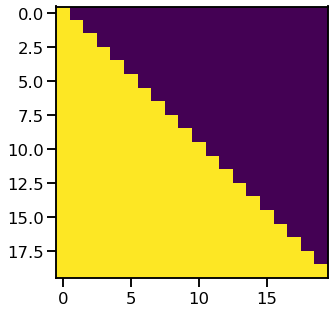

In [30]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])
plt.show()
# 각각의 타겟 단어(행)가 참조할 수 있는 범위(열)을 보여준다.

# Attention

In [12]:
def attention(query, key, value, mask=None, dropout=None):
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    
    if dropout is not None:
        p_attn = dropout(p_attn)
        
    return torch.matmul(p_attn, value), p_attn

# Multi-head-Attention

In [13]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h ==0
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
                            for l, x in zip(self.linears, (query, key, value))]
        
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        
        return self.linears[-1](x)

# Feed-Forward

In [14]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

# Embedding and Softmax

In [15]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model
        
    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

# position Encoding

In [16]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

# Model

In [21]:
def make_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
                           Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
                           nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
                           nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
                           Generator(d_model, tgt_vocab))
    
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

In [22]:
tmp_model = make_model(10, 10, 2)
None

<ipython-input-21-d94b2f2553f8>:16: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)


In [24]:
class Batch:
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not Nome:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
            
    def mask_std_mask(tgt, pad):
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

In [25]:
def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

In [26]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)